In [40]:
import numpy as np
import jax.numpy as jnp
from jax import random, jit
from matplotlib import pyplot as plt
from jaxopt import OptaxSolver
import optax

In [41]:
# Set input dimension
v = 1000

# Set data and target complexity
alpha = 0.75
beta = 0.25

D_vec = jnp.power(jnp.arange(v)+1,-2*alpha)
D = jnp.diag(D_vec)

# Define target
b = jnp.power(jnp.arange(v)+1,-beta)

key = random.key(0)

In [42]:
@jit
def loss(theta,W,data):
    X, y = data
    return jnp.mean((X @ W @ theta - y)**2)

In [43]:
# Sample a batch of size B
def generate_data(B,subkey):
    Z = random.normal(subkey,shape=(B,v))
    X = D_vec * Z
    y = jnp.dot(X,b)

    return X,y

In [44]:
# Approximation of risk / test error
@jit
def risk(theta,W):
    Wtheta = W @ theta
    return jnp.sum(jnp.diag(jnp.outer(Wtheta,Wtheta)) * D_vec) + jnp.sum(D_vec * b**2) - 2 * jnp.sum(jnp.diag(W @ jnp.outer(theta,b)) * D_vec)

In [45]:
def optimize(gamma,B,flops,d,W,key): 
    r = int(flops / (B*d))
    opt = optax.sgd(learning_rate=gamma)
    solver = OptaxSolver(opt=opt, fun=loss, maxiter=r, jit=True)
    theta = jnp.zeros(d)
    key, subkey = random.split(key)
    data = generate_data(B,subkey)
    state = solver.init_state(theta, W=W, data=data)

    for _ in range(r):
        key, subkey = random.split(key)
        data = generate_data(B,subkey)
        theta, state = solver.update(theta, state, W=W, data=data)

    err = risk(theta,W)

    return theta, err

In [46]:
flops = jnp.logspace(4,6,10)
n_sims = 5
B = 1
gamma = 0.1
dims = [100]
tau = 0
n_flops = jnp.shape(flops)[0]
n_dims = len(dims)
risks = np.zeros((n_flops,n_dims))


for j, d in enumerate(dims):
    key, subkey_Z = random.split(key)
    one = jnp.ones(shape=(d,))
    Z = random.normal(subkey_Z, shape=(v,d)) / jnp.sqrt(d)
    W = tau / jnp.sqrt(d) * jnp.outer(b,one) + Z    
    for i, C in enumerate(flops):
        print(C)
        err = 0
        for _ in range(n_sims):
            key, subkey_sgd = random.split(key)
            theta, err_k = optimize(gamma,B,C,d,W,subkey_sgd)
            err += err_k
        risks[i,j] = err / n_sims

10000.0
16681.01
27825.607
46415.87
77426.445
129154.984
215443.31
359381.6
599484.1
1000000.0


Text(0, 0.5, 'Risk')

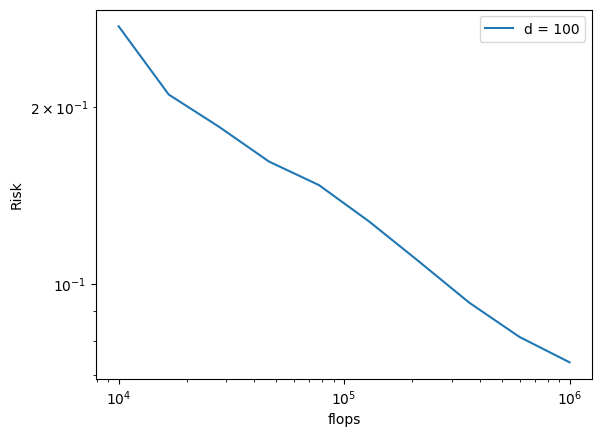

In [47]:
for j,d in enumerate(dims):
    plt.plot(flops,risks[:,j],label="d = {}".format(d))
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.xlabel("flops")
plt.ylabel("Risk")